In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm
from celmech import Andoyer
import rebound
from celmech.andoyer import get_Xstarres, get_Xstarunstable, get_Xstarnonres, get_Xsep
import pdb
from statsmodels.stats.weightstats import DescrStatsW
import corner
from tqdm import tqdm
from celmech.andoyer import get_Hsep
import glob
import pandas as pd
import spock
from spock import FeatureClassifier
from statsmodels.stats.weightstats import DescrStatsW
from scipy import stats

In [2]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rc('font', family='serif',size=20)
plt.rc('axes', linewidth=3.0)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20, direction='in')
plt.rc('ytick', labelsize=20, direction='in')
plt.rc('legend', fontsize=20)

# setting xtick parameters:

plt.rc('xtick.major',size=15,pad=8)
plt.rc('xtick.minor',size=10,pad=8)

plt.rc('ytick.major',size=15)
plt.rc('ytick.minor',size=10)

# Functions

In [3]:
# last TESS observation:
t_tess = 4664.65

# last K2 observation:
t_K2 = 2265

t = t_tess - t_K2

t_orbits = t/8.24958

#print('Number of orbits between observations: {:.0f}'.format(t_orbits))

t_orb = t_orbits*5.98
tmax = 1.0*t_orb
Nout = 200

t = np.linspace(0,tmax,Nout)
obs_tess = np.where(np.round(abs(t - t_orb),6) == np.round(np.min(abs(t - t_orb)),6))[0][0] 

delta_index = 0
obs_idx=[delta_index,obs_tess+delta_index] # [20, 519] in the current version

nobs = 2
obs_err = np.array([0.0001, 0.0005])
obs = np.array([1.503, 1.503]) 

def makesim(theta,dt=None):
    if dt==None:
        e_forced, e_free, mu, deltaT = theta
    else:
        e_forced, e_free, mu = theta[0], theta[1], theta[2]
        deltaT = dt
    mratio=0.5
    #e_com=float(np.random.uniform(0, 0.3, size=1)),  # varying between 0 and max(Z*) = 0.3
    e_com = 0.0
    phiecom=float(np.random.uniform(0, 2*np.pi, size=1)) # varying between 0 and 2pi
    #phiecom=0.0
    theta1 = np.pi
    #pomega_b=None
    
    Mstar = 1.1
    m1 = mratio*10**mu
    m2 = (1-mratio)*10**mu
    phi = np.pi # where equilibrium is
    theta1 = np.pi # so they start on opposite sides

    andvars = Andoyer.from_Z(j=3, k=1, Z=(e_forced+e_free)/np.sqrt(2), phi=phi, 
                             Zstar=e_forced/np.sqrt(2), Mstar=Mstar, m1=m1, m2=m2, 
                             Zcom=e_com/np.sqrt(2), phiZcom=phiecom, theta1=theta1)

    try:
        sim = andvars.to_Simulation()
        sim.integrator="whfast"
        sim.dt = sim.particles[1].P/20
        sim.ri_whfast.safe_mode = 0
        sim.integrate(deltaT)
        sim.t = 0
        return sim
    except:
        print(e_forced, e_free, deltaT, mu)
        raise
        
def run(sim):
    
    Pratios = np.zeros(Nout)
    ps = sim.particles

    for i, time in enumerate(t):
        
        sim.integrate(time)
        Pratios[i] = ps[2].P/ps[1].P
        
    return Pratios

def compute_model(theta):
    """
    Computes the model observation periods given a set of parameters at the observation indices
    """

    sim = makesim(theta)
    
    period_ratios = run(sim)

    return period_ratios[obs_idx]

def lnlike(theta):
    
    """
    Determines the gaussian log likelihood.
    obs: period ratio observations
    theta: parameters
    obs_err: errors in the shape of (obs,sample_size) for K2 and TESS
    """
    e_forced, e_free, mu, deltaT = theta
    
    model = compute_model(theta)
    #print(model)
    argument = (obs - model)**2 / obs_err**2

    loglike = 0.5*np.sum(argument)
    return loglike

In [68]:
def corner_plot(res_arr, preds_arr, sigma_limits, labels, weighted=True,pl_b=False,ecc_b=False, pl_e=False, ecc_e=False):
     
    if pl_b:
        ndim = np.shape(res_arr)[1]
    else:
        ndim = 3
    
    plt.rcParams['figure.facecolor'] = 'white'
    fig = corner.corner(
        np.array(res_arr), labels=labels,plot_contours=False, plot_density=False,#quantiles=[0.95],
        hist_kwargs={'color':'k','density':True,'zorder': 1},       
        plot_datapoints=False,
        weights=preds_arr
    )

    axes = np.array(fig.axes).reshape((ndim, ndim))
    for i,yi in enumerate(range(ndim)):
        
        for xi in range(yi):
            ax = axes[yi, xi]
             
            ax.scatter(np.array(res_arr)[:,xi][preds_arr!=0.0], np.array(res_arr)[:,yi][preds_arr!=0.0],
                       color="k", alpha=preds_arr[np.where(preds_arr != 0.0)], s=1.0,zorder=1)
            ax.scatter(np.array(res_arr)[:,xi][preds_arr==0.0], np.array(res_arr)[:,yi][preds_arr==0.0], 
                       color="r", 
                       alpha=0.1, s=1,zorder=0)

    
    if weighted==True:
        for i in range(ndim):
            ax = axes[i, i]
            ax.hist(np.array(res_arr)[:,i], color="red", histtype='step',density=True, zorder=0)
            ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(sigma_limits[i]), fontsize=15)
            ax.axvline(x=sigma_limits[i], ls='--',color='k')
            
            if pl_b:
                if i == 3:
                    ax.axvline(x=m_b_2sigma_rv, ls='--',color='g')
                    #ax.axvspan(-6.5, m_b_2sigma_rv, alpha=0.05, color='g')

                    ax.axvline(x=sigma_limits[3], ls='--',color='k')
                    #ax.axvspan(-6.5, sigma_limits[3], alpha=0.05, color='k')

                if ecc_b:
                    if i == 4:
                        ax.axvline(x=e_b_2sigma_rv, ls='--',color='g')
                        #ax.axvspan(0.0, e_b_2sigma_rv, alpha=0.05, color='g')

                        ax.axvline(x=sigma_limits[4], ls='--',color='k')
                        #ax.axvspan(0.0, sigma_limits[4], alpha=0.05, color='k')
    
    plt.show()

In [74]:
def get_Phinorm(post_array):
    np.random.seed(0)
    phi, Phinorm = np.zeros(len(post_array)), np.zeros(len(post_array))
    # see separatrix note on Dan's ipad
    for i, p in tqdm(enumerate(post_array)):
        sim = makesim(p, dt=0)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phiprime = andvars.Phiprime
        Xstarres = get_Xstarres(k, Phiprime)
        Xsep_inner, Xsep_outer = get_Xsep(k, Phiprime)
        Phistarres = Xstarres**2/2
        Phisep_outer = Xsep_outer**2/2
        sim = makesim(p, dt=np.random.random()*2000)
        andvars = Andoyer.from_Simulation(sim, j=j, k=k)
        Phinorm[i] = (andvars.Phi-Phistarres)/(Phisep_outer - Phistarres)
        phi[i] = andvars.phi
        
    return phi, Phinorm

def get_H(andvars):
    X = andvars.X
    Y = andvars.Y
    k = andvars.params['k']
    Phiprime = andvars.Phiprime
    H = (X**2 + Y**2)**2 - 3*Phiprime/2*(X**2+Y**2)+(X**2+Y**2)**((k-1)/2)*X 
    return H


def get_deltaH(post_array, j, k, i1, i2, pl_b=True):

    #j1 = 3
    #j2 = 2
    #k = 1

    deltaH = []

    for i,param in tqdm(enumerate(post_array)):
        sim = makesim(param[:4],dt=0)
        
        if pl_b:
            m_b = 10**param[-2]
            e_b = param[-1]

            pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
            sim.add(m=m_b, P=sim.particles[2].P*1.946, e=e_b, pomega=pomega_b, theta=np.pi/2)
        
        #if both:
        andvars = Andoyer.from_Simulation(sim, j=j, k=k, i1=i1, i2=i2)

        H = get_H(andvars)
        Hsep = get_Hsep(k, andvars.Phiprime)

        deltaH.append(H-Hsep)
        
    return deltaH

# Reading the rejection posteriors

In [5]:
path = '/Users/Helios/gdrive_pu/tamayo_research/lnlike_60mil/'
params = [np.load(file, allow_pickle=True) for file in glob.iglob(path+'/*.npy', recursive=True)]

par_con = np.concatenate(params)
print(len(par_con))

like_output = par_con[pd.notnull(par_con)]

print(len(like_output))

params = [list(like_output[i][:2]) for i in range(len(like_output))]
#mus = [np.log10((10**like_output[i][-1])/9.54e-4) for i in range(len(like_output))]
mus = [like_output[i][-1] for i in range(len(like_output))]
deltaTs = [like_output[i][2] for i in range(len(like_output))]

like_output = []

for p,mu,T in zip(params,mus,deltaTs):
    r = list(p)
    r.append(mu)
    r.append(T)
    
    like_output.append(r)

61700000
9693


In [7]:
# rv sampling posterior: (eforced, efree, mu (solar mass dex), deltaT, mb (solar mass dex), eb)

rv_post = np.load('stability_posteriors/100k_rv_priors_100mil_lnlike.npy')

In [8]:
# spock predictions
preds_rv = np.load('stability_posteriors/100k_rv_stability_preds.npy')

In [105]:
# Energies of each configuration

# c--d 3:2 resonance
deltaH_cd = get_deltaH(rv_post,j=3, k=1, i1=1, i2=2)

# d--b 2:1 resonance
deltaH_db = get_deltaH(rv_post,j=2, k=1, i1=2, i2=3)

print(len(deltaH_cd))
print(len(deltaH_db))

1it [00:00,  7.30it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:52: UserWarning: k=1 resonance has no unstable fixed point for Phiprime < 1
  warnings.warn("k=1 resonance has no unstable fixed point for Phiprime < 1")
/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:91: UserWarning: There is no separatrix for the passed value of Phiprime
  warnings.warn("There is no separatrix for the passed value of Phiprime")
100000it [17:06, 97.42it/s]
100000it [17:58, 92.68it/s]

100000
100000


In [106]:
rv_inres = np.array(rv_post)[np.array(deltaH_cd) < 0.0] 
rv_outres = np.array(rv_post)[(np.array(deltaH_cd) >= 0.0) | np.isnan(np.array(deltaH_cd))]

print(len(rv_inres))
print(len(rv_outres))

21586
78414


In [107]:
inres_params = [param[:3] for param in rv_inres]
outres_params = [param[:3] for param in rv_outres]

In [108]:
inres_params[0]

array([ 0.04905421,  0.00495659, -4.71219351])

In [109]:
spock_inres = np.array(preds_rv)[np.array(deltaH_cd) < 0]
spock_outres = np.array(preds_rv)[(np.array(deltaH_cd) > 0.0) | np.isnan(np.array(deltaH_cd))]

print(len(spock_inres))
print(len(spock_outres))

21586
78414


In [110]:
sigma=0.997
threesig_inres = [float(DescrStatsW(data=np.array(inres_params)[:,i], 
                                    weights=spock_inres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(inres_params)[1])]
threesig_outres = [float(DescrStatsW(data=np.array(outres_params)[:,i], 
                                     weights=spock_outres).quantile(probs=np.array([sigma]), 
                                                 return_pandas=False)) for i in range(np.shape(outres_params)[1])]

In [111]:
threesig_inres

[0.1858439871507199, 0.02975256372066078, -3.0637655642668418]

# Figure 1 Corner plots

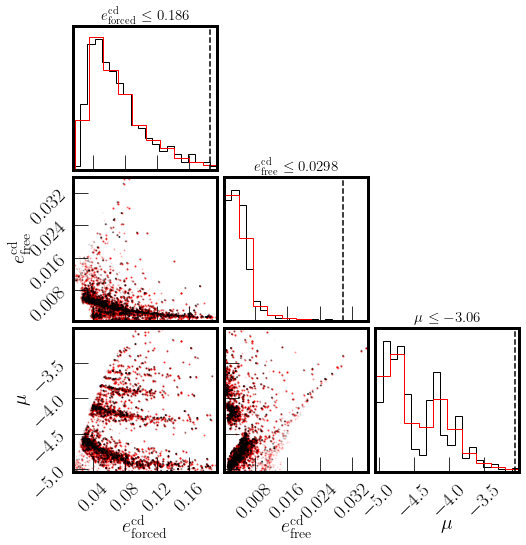

In [51]:
%matplotlib inline
ndim = np.shape(inres_params)[1]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(inres_params), labels=labels,plot_contours=False, plot_density=False,
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    weights=spock_inres
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(inres_params)[:,xi][spock_inres!=0.0], np.array(inres_params)[:,yi][spock_inres!=0.0],
                   color="k", alpha=spock_inres[spock_inres != 0.0], s=1,zorder=1)
        ax.scatter(np.array(inres_params)[:,xi][spock_inres==0.0], np.array(inres_params)[:,yi][spock_inres==0.0], 
                   color="r", 
                   alpha=0.1, s=1,zorder=0)

for i in range(ndim):
    ax = axes[i, i]
    ax.hist(np.array(inres_params)[:,i][spock_inres!=0.0], color="r", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(threesig_inres[i]), fontsize=15)
    ax.axvline(x=threesig_inres[i], ls='--',color='k')
#plt.savefig('figures/Figure2b.pdf',dpi=300,bbox_inches='tight',padding=0)

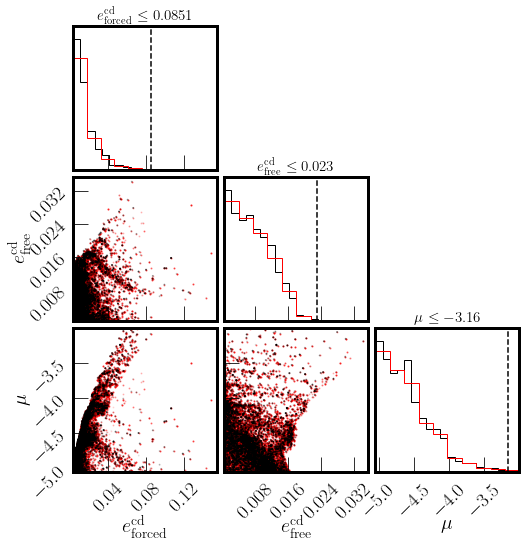

In [54]:
%matplotlib inline
ndim = np.shape(outres_params)[1]
labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$"]
plt.rcParams['figure.facecolor'] = 'white'
fig = corner.corner(
    np.array(outres_params), labels=labels,plot_contours=False, plot_density=False,
    hist_kwargs={'density':True},       
    plot_datapoints=False,
    weights=spock_outres
)

axes = np.array(fig.axes).reshape((ndim, ndim))
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.scatter(np.array(outres_params)[:,xi][spock_outres!=0.0], np.array(outres_params)[:,yi][spock_outres!=0.0],
                   color="k", alpha=spock_outres[spock_outres != 0.0], s=1,zorder=1)
        ax.scatter(np.array(outres_params)[:,xi][spock_outres==0.0], np.array(outres_params)[:,yi][spock_outres==0.0], 
                   color="r", 
                   alpha=0.1, s=1,zorder=0)

for i in range(ndim):
    ax = axes[i, i]
    ax.hist(np.array(outres_params)[:,i][spock_outres!=0.0], color="r", histtype='step',density=True)
    ax.set_title(labels[i]+" $ \\leq {0:.3g}$".format(threesig_outres[i]), fontsize=15)
    ax.axvline(x=threesig_outres[i], ls='--',color='k')

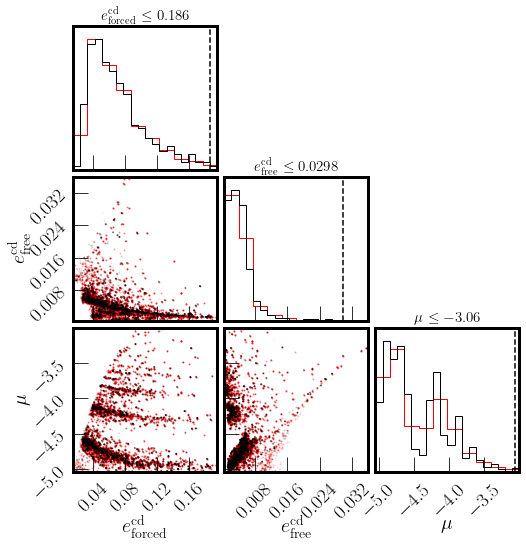

In [69]:
corner_plot(inres_params, spock_inres, threesig_inres, pl_b=False, weighted=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

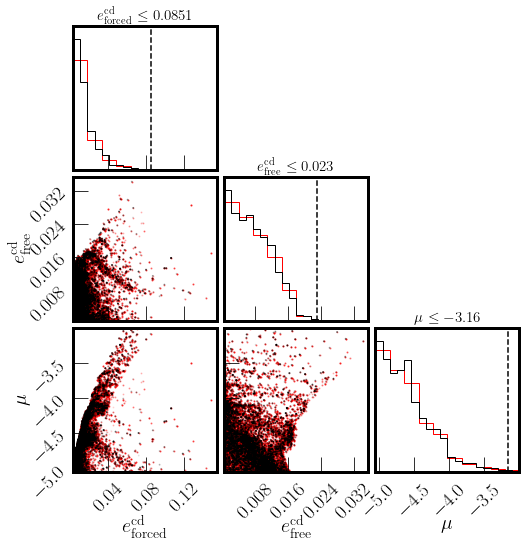

In [70]:
corner_plot(outres_params, spock_outres, threesig_outres, pl_b=False, weighted=True,
            labels=["$e_{\\rm{forced}}^{\\rm{cd}}$", "$e_{\\rm{free}}^{\\rm{cd}}$", "$\mu$", "$M_b$", "$e_b$"], 
           )

## Time series panels

100it [00:01, 56.08it/s]


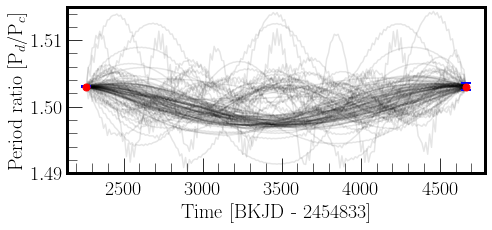

In [66]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_inres[:100])):
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.515)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

100it [00:01, 57.81it/s]


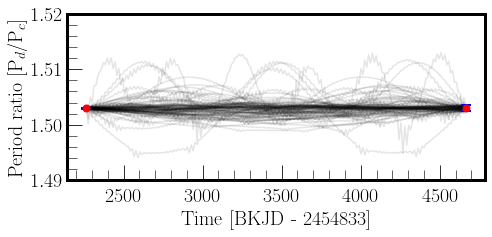

In [67]:
fig = plt.figure(1,figsize=(2.2*3.4, 1.2*3.4*3/4.))
ax = fig.add_subplot(111)
time_grid = np.linspace(t_K2, t_tess, Nout)

for i,param in tqdm(enumerate(rv_outres[:100])):
    p = param[:4]
    
    sim = makesim(p)
    #pomega_b = float(np.random.uniform(0, 2*np.pi, size=1))
    
    #sim.add(m=10**param[-2], P=sim.particles[2].P*1.946, e=param[-1], pomega=pomega_b, theta=np.pi/2)
    period_ratios = run(sim)
    
    ax.plot(time_grid,period_ratios,
         alpha=0.1,zorder=0, c='k',
         rasterized=True)

#ax1.plot(time_grid, run(makesim(min_mu[0][:4])), c='C2')

ax.errorbar(time_grid[[0, -1]],obs,yerr=obs_err, fmt='o',ms=7, c='r',ecolor='b',zorder=1,capsize=5, capthick=2)
ax.set_ylabel('Period ratio [P$_d$/P$_c$]',fontsize=20)
ax.set_ylim(1.49, 1.520)
ax.set_xlabel('Time [BKJD - 2454833]',fontsize=20)

ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

ax.minorticks_on()
plt.show()

# Figure 2

In [71]:
rv_inres_deltaT = [param[:4] for param in rv_inres]

In [75]:
j=3
k=1
phi_rv, Phinorm_rv = get_Phinorm(rv_inres_deltaT)

93it [00:02, 43.92it/s]/Users/Helios/opt/anaconda3/lib/python3.8/site-packages/celmech/andoyer.py:98: UserWarning: k=1 resonance has no separatrix for Phiprime < 1
  warnings.warn("k=1 resonance has no separatrix for Phiprime < 1")
21587it [08:34, 42.00it/s]


<ipython-input-101-8d7c004007f3>:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)


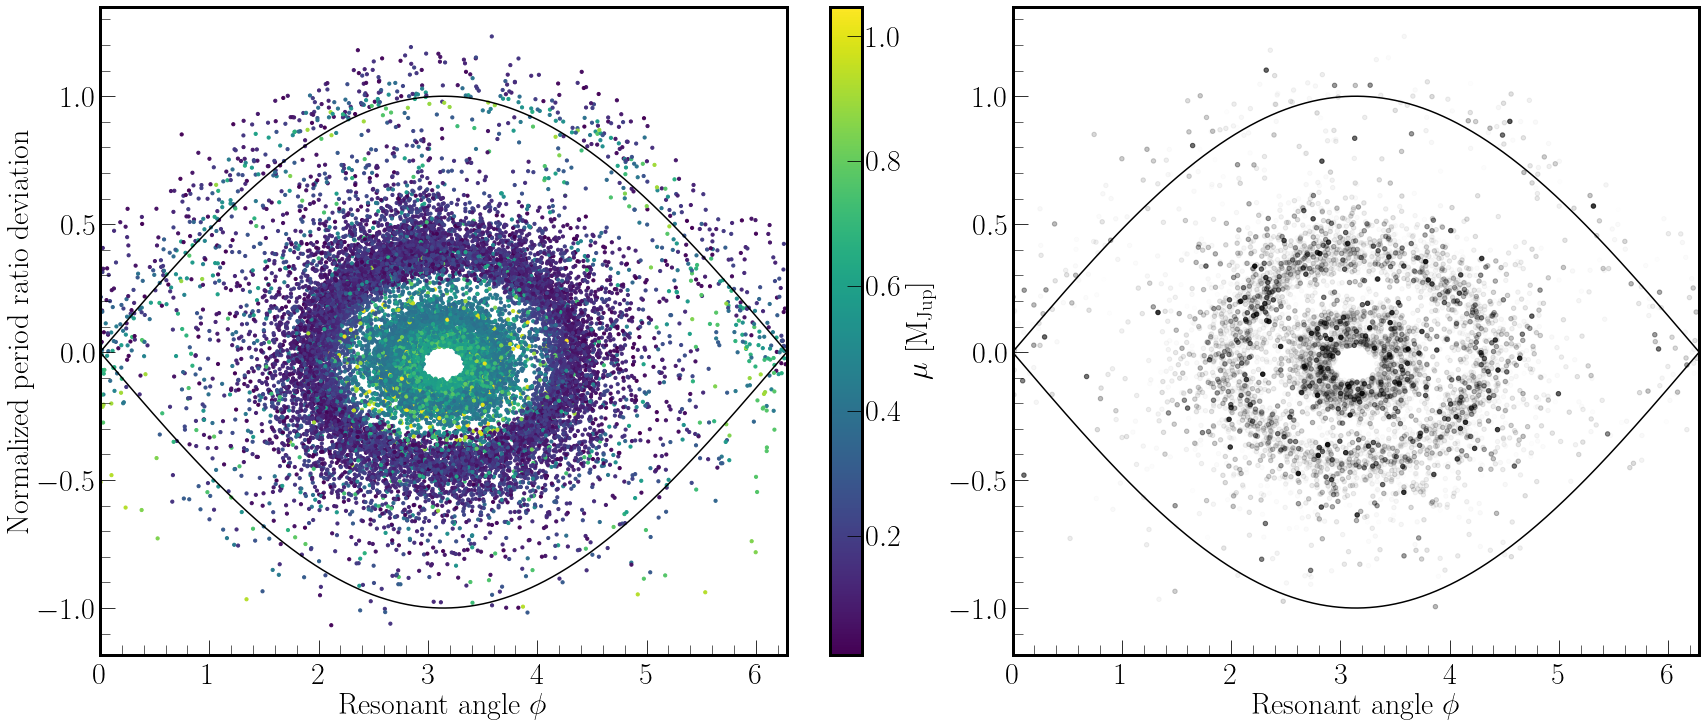

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7*3.4, 4.0*3.4*3/4.),
                         gridspec_kw={'width_ratios': [1, 0.80]})
ax1 = axes[0]
ax2 = axes[1]

phis = np.linspace(0, 2*np.pi, 1000)
sep_upper = np.sin(phis/2)
ax1.plot(phis, sep_upper, 'k')
ax1.plot(phis, -sep_upper, 'k')
ax1.set_xlim([0,2*np.pi])
ax1.set_xlabel('Resonant angle $\phi$',fontsize=30)
ax1.set_ylabel('Normalized period ratio deviation',fontsize=30)
#cb = ax.scatter(phi, Phinorm, c=spock_prob, alpha=spock_prob, s=20)

#cb=ax1.scatter(phi_rv, Phinorm_rv, 
#              c=[(10**(param[2]))/9.54e-4 for param in rv_inres], 
#              s=10, rasterized=True)
ax1.scatter(phi_rv, Phinorm_rv, 
              c=[param[2] for param in rv_inres], 
              s=10, rasterized=True)

cbar1 = fig.colorbar(cb, ax=ax1)
cbar1.set_label(r'$\mu$ [M$_{\rm{Jup}}$]', fontsize=30)
cbar1.ax.tick_params(labelsize=30)

ax2.plot(phis, sep_upper, 'k')
ax2.plot(phis, -sep_upper, 'k')
ax2.set_xlim([0,2*np.pi])
ax2.set_xlabel('Resonant angle $\phi$',fontsize=30)
#ax2.set_ylabel('Normalized period ratio deviation',fontsize=30)

cb2=ax2.scatter(phi_rv, Phinorm_rv, 
              alpha=[prob for prob in spock_inres],c='k', 
              s=20) 

ax1.minorticks_on()
ax2.minorticks_on()

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)

ax2.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='x', labelsize=30)

plt.tight_layout()
plt.subplots_adjust(wspace=0.07)
plt.savefig('figures/Figure2_stability.pdf',dpi=300,bbox_inches='tight',padding=0)

# Figure 3

In [112]:
mb_array = (10**np.array([rv_post[i][-2] for i in range(len(rv_post))]))/9.54e-4
eb_array = np.array([rv_post[i][-1] for i in range(len(rv_post))])

In [113]:
print('Stable resonant:',len(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] < 0]))
print('Stable non-resonant:',
      len(mb_array[preds_rv > 0.0][np.array(deltaH_db)[preds_rv > 0.0] >= 0]))

Stable resonant: 1901
Stable non-resonant: 27784


In [114]:
print('Unstable resonant:',
      len(mb_array[preds_rv == 0.0][np.array(deltaH_db)[preds_rv == 0.0] < 0]))
print('Unstable non-resonant:',
      len(mb_array[preds_rv == 0.0][np.array(deltaH_db)[preds_rv == 0.0] >= 0]))

Unstable resonant: 4428
Unstable non-resonant: 65887


In [115]:
logu_post = np.load('stability_posteriors/100k_logu_priors.npy')
preds_logu = np.load('stability_posteriors/100k_logu_stability_preds.npy')

In [116]:
deltaH_cd_logu = get_deltaH(logu_post,j=3, k=1, i1=1, i2=2)
deltaH_db_logu = get_deltaH(logu_post,j=2, k=1, i1=2, i2=3)

np.save('stability_posteriors/deltaH_cd_logu.npy',deltaH_cd_logu)
np.save('stability_posteriors/deltaH_db_logu.npy',deltaH_db_logu)

100000it [17:43, 94.06it/s]
100000it [17:28, 95.35it/s]
